<h1>An introduction to S3, Boto and Nexrad on S3</h1>

<!--  Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. -->
<!-- !-- SPDX-License-Identifier: MIT-0 -->

Adapted from <a href="https://github.com/openradar/AMS_radar_in_the_cloud">AMS Short Course</a> which was adapted and thank to the <a href="https://eng.climate.com/2015/10/27/how-to-read-and-display-nexrad-on-aws-using-python/">first tutorial</a> by Valliappa Lakshmanan, formerly at Climate Corp now at Google.

<a href="https://aws.amazon.com/s3">Amazon Simple Storage Service (Amazon S3)</a> is object storage with a simple web service interface to store and retrieve any amount of data from anywhere on the web. It is designed to deliver 99.999999999% durability, and scale past trillions of objects worldwide.

<a href="https://github.com/boto/boto3">Boto3</a> is a Python package that provides interfaces to Amazon Web Services.

In [1]:
# install cartopy in the default conda env:
#     source activate default
#     conda install python=3.8

# install cartopy in the default conda env:
#     conda install cartopy
# restart the kernel

In [2]:
# %pip install jupyter netcdf4 numpy matplotlib

In [3]:
import boto3
from boto.s3.connection import S3Connection
from datetime import timedelta, datetime
import os
import pyart
from matplotlib import pyplot as plt
import tempfile
import numpy as np

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [4]:
conn = S3Connection(anon = True)
bucket = conn.get_bucket('noaa-nexrad-level2')

From https://aws.amazon.com/noaa-big-data/nexrad/ :

The NEXRAD Level II archive data is hosted in the “noaa-nexrad-level2” Amazon S3 bucket in S3’s US East region. The address for the public bucket is:

    http://noaa-nexrad-level2.s3.amazonaws.com

    https://noaa-nexrad-level2.s3.amazonaws.com

Each volume scan file is its own object in Amazon S3. The basic data format is the following:
    /<Year>/<Month>/<Day>/<NEXRAD Station>/<filename>

Where:

    is the year the data was collected
    is the month of the year the data was collected
    is the day of the month the data was collected
    is the NEXRAD ground station (map of ground stations)
    is the name of the file containing the data. 
These are compressed files (compressed with gzip). The file name has more precise timestamp information.

All files in the archive use the same compressed format (.gz). The data file names are, for example, KAKQ20010101_080138.gz. The file naming convention is:

    GGGGYYYYMMDD_TTTTTT

Where:

    GGGG = Ground station ID (map of ground stations) 
    YYYY = year 
    MM = month 
    DD = day 
    TTTTTT = time when data started to be collected (GMT)

Note that the 2015 files have an additional field on the file name. It adds “_V06” to the end of the file name. An example is KABX20150303_001050_V06.gz.

In [5]:
my_pref = '2011/05/20/KVNX/'
bucket_list = list(bucket.list(prefix = my_pref))

In [6]:
home_dir = os.path.expanduser('~')
bucket_list[0].get_contents_to_filename(os.path.join(home_dir,'nexrad_tempfile'))

In [7]:
radar = pyart.io.read(os.path.join(home_dir,'nexrad_tempfile'))
# print(radar.info())

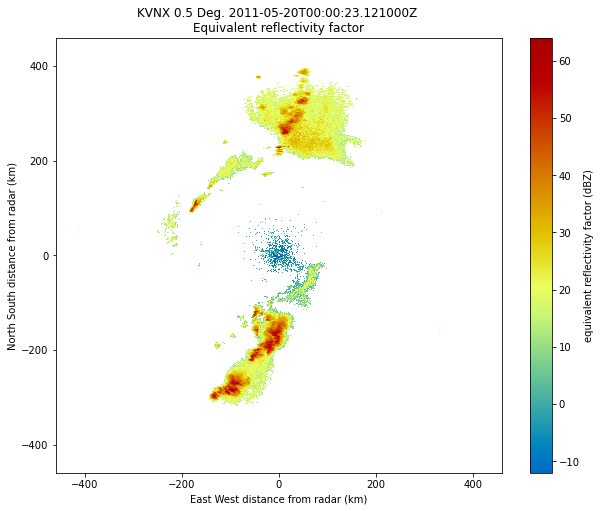

In [8]:
my_figure = plt.figure(figsize = [10,8])
my_display = pyart.graph.RadarDisplay(radar)
my_display.plot_ppi('reflectivity', 0, vmin = -12, vmax = 64)

In [9]:
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))

def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data

    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    #Connect to the bucket

    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    #Get a list of files

    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys and datetimes to allow easy searching

    keys = []
    datetimes = []

    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

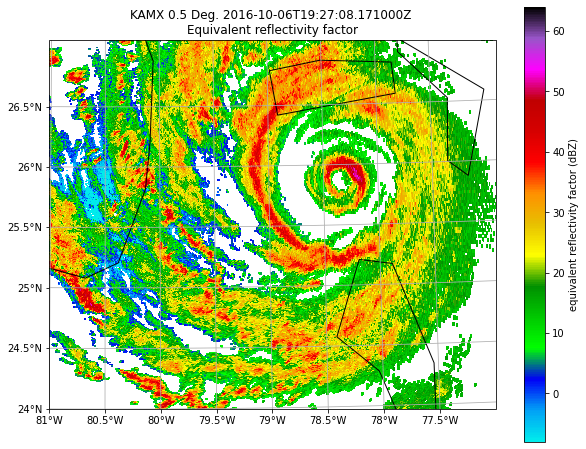

In [10]:
import warnings
# there is a float deprecation warning that we'll ignore for now
warnings.filterwarnings('ignore')

base_date = "20161006_192700"
fmt = '%Y%m%d_%H%M%S' 
b_d = datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KAMX',b_d )
max_lat = 27
min_lat = 24
min_lon = -81
max_lon = -77

lal = np.arange(min_lat, max_lat, .5)
lol = np.arange(min_lon, max_lon, .5)

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = '110m',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)